# Predicting Customer Churn For Retail Banking
<h3><span style="color: #117d30;"> Predicting whether a retail banking customer is likely to churn</span></h3>


## Disclaimer

By accessing this code, you acknowledge the code is made available for presentation and demonstration purposes only and that the code (1) is not subject to SOC 1 and SOC 2 compliance audits, and (2) is not designed or intended to be a substitute for the professional advice, diagnosis, treatment, or judgment of a certified financial services professional. Do not use this code to replace, substitute, or provide professional financial advice, or judgement. You are solely responsible for ensuring the regulatory, legal, and/or contractual compliance of any use of the code, including obtaining any authorizations or consents, and any solution you choose to build that incorporates this code in whole or in part.

© 2021 Microsoft Corporation. All rights reserved

### Introduction
In this example we use historical retail banking data to build an AutoML classification model to predict whether a retail banking customer is likely to churn or not. The objective is to predict **Churn Ratio** for the retail banking business, which is defined as the proportion of all retail banking customers that are likely to churn, in near future.  

### Importing required libraries and dependencies



In [1]:
## Importing required libraries 
import azureml.core
from azureml.core import Workspace, Datastore, Dataset, Experiment
from azureml.data import DataType
from azureml.data.datapath import DataPath

## Importing libraries specific to AutoML  
from azureml.core.compute import AmlCompute
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun

## We will be reading data as a Pandas dataframe   
import pandas as pd
## Python SDK version 
print("SDK Version:", azureml.core.VERSION)

SDK Version: 1.32.0


In [2]:
import GlobalVariables 

In [3]:
## Printing the ML workspace details    
import os


ws = Workspace(subscription_id= "#SUBSCRIPTION_ID#",
                resource_group= "#RESOURCE_GROUP_NAME#",
                workspace_name= "#WORKSPACE_NAME#")
ws


Workspace.create(name='#WORKSPACE_NAME#', subscription_id='#SUBSCRIPTION_ID#', resource_group='#RESOURCE_GROUP_NAME#')

### Pre-processing the data

#### Loading  the data
Load the historical retail banking customer dataset
 

In [4]:
## Data is already registered in ML workspace, as a tabular data     
churndata = ws.datasets['customer_churn']

#### Convert to Pandas dataframe 

In [5]:
## Converting the tabular data to a pandas dataframe 
churndata_pd = churndata.to_pandas_dataframe()
churndata_pd.head()

,Column1,age,marital,housing,loan,contact,pdays,previous,emp.var.rate,cons.price.idx,...,job_admin.,job_blue-collar,job_entrepreneur,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed
0,0,56,1,1,1,1,999,0,1.1,93.994,...,0,0,0,0,0,0,0,0,0,0
1,1,57,1,1,1,1,999,0,1.1,93.994,...,0,0,0,0,0,0,1,0,0,0
2,2,37,1,2,1,1,999,0,1.1,93.994,...,0,0,0,0,0,0,1,0,0,0
3,3,40,1,1,1,1,999,0,1.1,93.994,...,1,0,0,0,0,0,0,0,0,0
4,4,56,1,1,2,1,999,0,1.1,93.994,...,0,0,0,0,0,0,1,0,0,0


In [6]:
# View info to see what the column names and types are
churndata_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 33 columns):
Column1                          41188 non-null int64
age                              41188 non-null int64
marital                          41188 non-null int64
housing                          41188 non-null int64
loan                             41188 non-null int64
contact                          41188 non-null int64
pdays                            41188 non-null int64
previous                         41188 non-null int64
emp.var.rate                     41188 non-null float64
cons.price.idx                   41188 non-null float64
cons.conf.idx                    41188 non-null float64
euribor3m                        41188 non-null float64
nr.employed                      41188 non-null float64
y                                41188 non-null int64
education_basic.4y               41188 non-null int64
education_basic.6y               41188 non-null int64
education_basic.9

#### Set up AutoML Experiment 

In [7]:
# select compute
compute = AmlCompute(ws, GlobalVariables.COMPUTE_AIML)

# choose a name for experiment
experiment_name = 'automl_churn_experiment'
experiment = Experiment(ws, experiment_name)
print(experiment)

Experiment(Name: automl_churn_experiment,
Workspace: #WORKSPACE_NAME#)


#### Set up AutoML Configuration

In [8]:
## Define the target variable or the label 
label= 'y'  

## Setting up AutoML configuration
automl_config = AutoMLConfig(task='classification',
                            primary_metric='AUC_weighted',   
                            debug_log='automl_errors.log',
                            iteration_timeout_minutes = 15,
                            experiment_timeout_minutes = 15,
                            label_column_name=label,
                            enable_early_stopping=True,
                            compute_target=compute,
                            training_data=churndata,
                            n_cross_validations=5,
                            model_explainability=True)

#### Configure the AutoML model and run it

In [9]:
## Run experiment
## This code clock takes approx.25-30 minutes  
training_run = experiment.submit(automl_config, show_output = True)

Submitting remote run.
No run_configuration provided, running on fsi-compute-prod with default configuration
Running on remote compute: fsi-compute-prod


Experiment,Id,Type,Status,Details Page,Docs Page
automl_churn_experiment,AutoML_f92635f6-21f5-4bd9-9cbd-522c550681e5,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation



Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetFeaturization. Beginning to fit featurizers and featurize the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       ALERTED
DESCRIPTION:  To decrease model bias, please cancel the current run and fix balancing problem.
              Learn more about imbalanced data: https://aka.ms/AutomatedMLImbalancedData
DETAILS:      Imbalanced data can lead to a falsely perceived positive effect of a model's accuracy because the input data has bias towards one class.
+---------------------------------+---------------------------------+--------------------------------------+
|Size of the smallest class       |Name/Label of the sm

### Results

#### Monitor Runs

In [10]:
# Print training runs
from azureml.widgets import RunDetails
RunDetails(training_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

In [11]:
## Show training run outputs
training_run.wait_for_completion(show_output=False)

{'runId': 'AutoML_f92635f6-21f5-4bd9-9cbd-522c550681e5',
 'target': 'fsi-compute-prod',
 'status': 'Completed',
 'startTimeUtc': '2021-07-27T22:03:41.791237Z',
 'endTimeUtc': '2021-07-27T22:28:38.356032Z',
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'AUC_weighted',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': '5',
  'target': 'fsi-compute-prod',
  'AMLSettingsJsonString': '{"path":null,"name":"automl_churn_experiment","subscription_id":"#SUBSCRIPTION_ID#","resource_group":"#RESOURCE_GROUP_NAME#","workspace_name":"#WORKSPACE_NAME#","region":"westus2","compute_target":"fsi-compute-prod","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_batch_size":1,"enable_batch_run":false,"enable_run_restructure":false,"start_auxiliary_runs_before_parent_complete":false,"enable_code_generation":false,"iterations":1000,"primary_metric":"AUC_weighted","t

### Retrieve the Best Model from AutoML Run

In [12]:
best_run, fitted_model = training_run.get_output()
fitted_model

Package:azureml-automl-runtime, training version:1.32.0, current version:1.31.0
Package:azureml-dataset-runtime, training version:1.32.0, current version:1.31.0
Package:azureml-defaults, training version:1.32.0, current version:1.31.0
Package:azureml-interpret, training version:1.32.0, current version:1.31.0
Package:azureml-mlflow, training version:1.32.0, current version:1.31.0
Package:azureml-pipeline-core, training version:1.32.0, current version:1.31.0
Package:azureml-telemetry, training version:1.32.0, current version:1.31.0
Package:azureml-train-automl-client, training version:1.32.0, current version:1.31.0
Package:azureml-train-automl-runtime, training version:1.32.0, current version:1.31.0


Pipeline(memory=None,
         steps=[('datatransformer',
                 DataTransformer(enable_dnn=False, enable_feature_sweeping=True, feature_sweeping_config={}, feature_sweeping_timeout=86400, featurization_config=None, force_text_dnn=False, is_cross_validation=True, is_onnx_compatible=False, observer=None, task='classification', working_dir='/mnt/batch/tasks/shared/LS_root/mount...
    subsampling_schedule='hyperband_clip',
    cost_mode_param=None,
    iteration_timeout_mode=0,
    iteration_timeout_param=None,
    feature_column_names=None,
    label_column_name=None,
    weight_column_name=None,
    cv_split_column_names=None,
    enable_streaming=None,
    timeseries_param_dict=None,
    gpu_training_param_dict={'processing_unit_type': 'cpu'}
), random_state=0, tree_method='auto'))],
         verbose=False)

### Calculate metrics for the prediction

Now visualize the data on a scatter plot to show what our actual values are compared to the predicted values 
from the trained model that was returned.

In [13]:
# We'll get prediction for complete dataset as test   
X_test_df = churndata.drop_columns(columns=['y']).to_pandas_dataframe()
y_test_df = churndata.keep_columns(columns=['y'], validate=True).to_pandas_dataframe()

In [14]:
# call the predict functions on the model
y_pred = fitted_model.predict(X_test_df)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

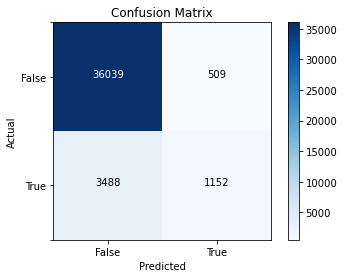

In [15]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

cf =confusion_matrix(y_test_df.values,y_pred)
plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
class_labels = ['False','True']
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks,class_labels)
plt.yticks([-0.5,0,1,1.5],['','False','True',''])
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show()

## Calculate the Churn Ratio 

Churn ratio is defined here as the percentage of all the retail customers who are likely to churn 

In [16]:
# Churn Ratio 
churn_predicted = pd.DataFrame(y_pred, columns = ['Churn_Predicted'])
(churn_predicted['Churn_Predicted'].value_counts()/churn_predicted['Churn_Predicted'].count())*100

0   95.97
1    4.03
Name: Churn_Predicted, dtype: float64

## Predicted Churn Ratio is 4.03% 